## Импорт библиотек и установка настроек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mlp

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)
mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 10
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 10

mlp.rcParams['ytick.major.size'] = 10
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 10

## Чтение данных из файлов

In [2]:
user_df =  pd.read_csv('user_df.csv')
feed_df = pd.read_csv('feed_df.csv', parse_dates=['time'])
post_df = pd.read_csv('post_df.csv')

## EDA

In [3]:
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [4]:
feed_df.head()

,post_id,user_id,action,target,time
0,5334,83781,view,0,2021-10-12 17:14:30
1,3811,83781,view,0,2021-10-12 17:16:51
2,706,83781,view,0,2021-10-12 17:18:02
3,7193,83781,view,0,2021-10-12 17:18:28
4,3846,83781,view,0,2021-10-12 17:21:21


In [5]:
post_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [6]:
# Проверяем наличие пустых значений в датафреймах
print(f"user_df check \n{user_df.isnull().sum()}")
print(f"post_df check \n{post_df.isnull().sum()}")
print(f"feed_df check \n{feed_df.isnull().sum()}")

user_df check 
user_id      0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
dtype: int64
post_df check 
post_id    0
text       0
topic      0
dtype: int64
feed_df check 
post_id    0
user_id    0
action     0
target     0
time       0
dtype: int64


In [7]:
user_df.describe(include = 'all')

,user_id,gender,age,country,city,exp_group,os,source
count,159875.000000,159875.000000,159875.000000,159875,159875,159875.000000,159875,159875
unique,NaN,NaN,NaN,11,3900,NaN,2,2
top,NaN,NaN,NaN,Russia,Moscow,NaN,Android,ads
freq,NaN,NaN,NaN,140124,21434,NaN,103842,99645
mean,85029.191243,0.551418,26.531215,NaN,NaN,1.997511,NaN,NaN
std,48962.628764,0.497351,9.211525,NaN,NaN,1.413574,NaN,NaN
min,200.000000,0.000000,14.000000,NaN,NaN,0.000000,NaN,NaN
25%,41001.500000,0.000000,19.000000,NaN,NaN,1.000000,NaN,NaN
50%,85429.000000,1.000000,24.000000,NaN,NaN,2.000000,NaN,NaN
75%,127679.500000,1.000000,32.000000,NaN,NaN,3.000000,NaN,NaN


In [8]:
post_df.describe(include = 'all')

,post_id,text,topic
count,7023.000000,7023,7023
unique,NaN,6924,7
top,NaN,Microsoft gets the blogging bug\n\nSoftware gi...,movie
freq,NaN,2,3000
mean,3666.533817,NaN,NaN
std,2109.613383,NaN,NaN
min,1.000000,NaN,NaN
25%,1849.500000,NaN,NaN
50%,3668.000000,NaN,NaN
75%,5492.000000,NaN,NaN


In [9]:
feed_df.describe(include = 'all')

,post_id,user_id,action,target,time
count,1000000.000000,1000000.000000,1000000,1000000.000000,1000000
unique,NaN,NaN,2,NaN,652810
top,NaN,NaN,view,NaN,2021-11-18 10:45:49
freq,NaN,NaN,893556,NaN,9
first,NaN,NaN,NaN,NaN,2021-10-01 06:06:45
last,NaN,NaN,NaN,NaN,2021-12-29 23:51:06
mean,3397.016355,72513.094098,NaN,0.106445,NaN
std,2096.840057,46115.179463,NaN,0.308406,NaN
min,1.000000,11652.000000,NaN,0.000000,NaN
25%,1528.000000,32824.000000,NaN,0.000000,NaN


In [10]:
# Удаляем дубли если они есть
print(user_df.shape)
user_df.drop_duplicates(inplace = True)
print(user_df.shape)

print(post_df.shape)
post_df.drop_duplicates(inplace = True)
print(post_df.shape)

print(feed_df.shape)
feed_df.drop_duplicates(inplace = True)
print(feed_df.shape)

(159875, 8)
(159875, 8)
(7023, 3)
(7023, 3)
(1000000, 5)
(1000000, 5)


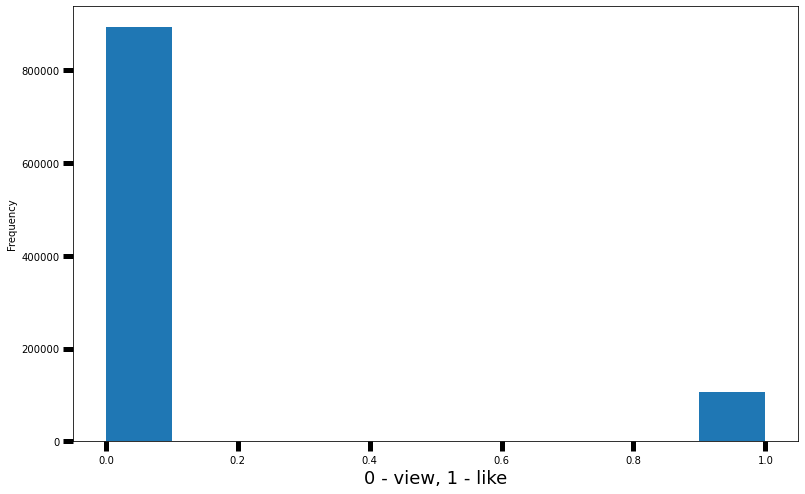

In [11]:
# Смотрим есть ли дисбаланс в наших классах в таргете
plt.figure(figsize=(13,8))
plt.xlabel('0 - view, 1 - like', fontsize = 18)
feed_df.target.plot(kind = 'hist',);

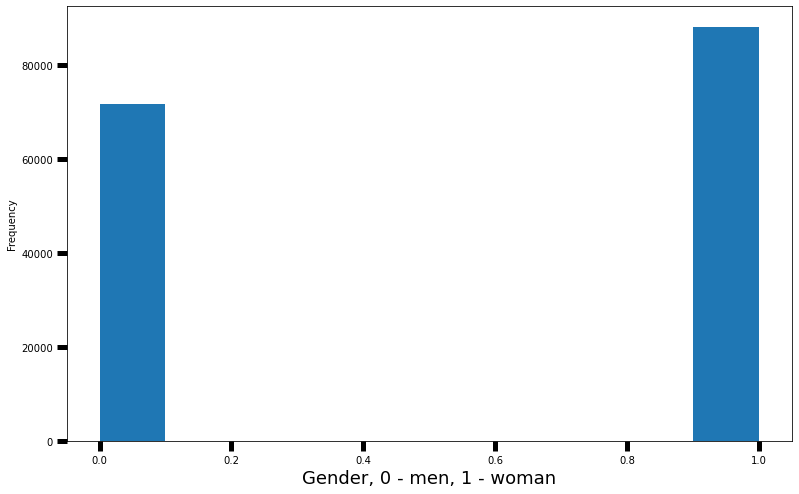

In [12]:
# В данных больше женщин чем мужчин
plt.figure(figsize=(13,8))
plt.xlabel('Gender, 0 - men, 1 - woman', fontsize = 18)
user_df.gender.plot(kind = 'hist',);

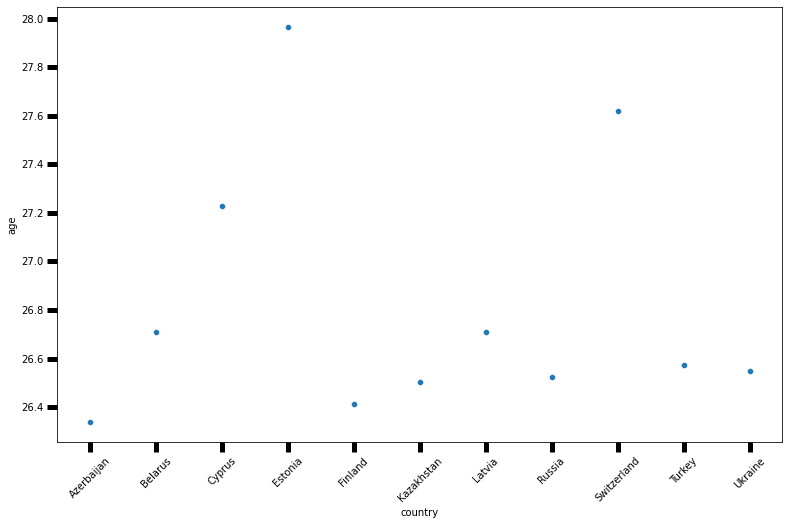

In [13]:
# Находим средний возраст в разрезе каждой страны
mean_age = user_df.groupby('country').age.mean()

plt.figure(figsize=(13,8))
sns.scatterplot(x = mean_age.index, y = mean_age)
plt.xticks(rotation = 45);

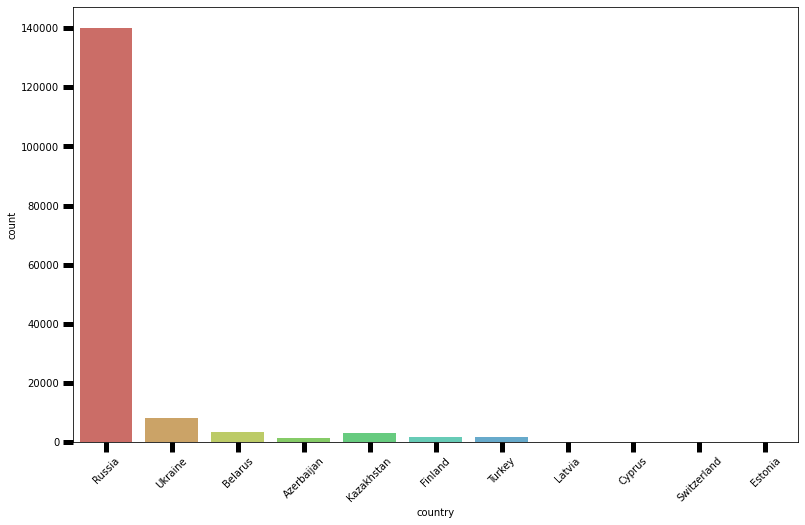

In [14]:
# Смотрим из какой страны наибольшее кол-во пользователей в социальной сети
plt.figure(figsize=(13,8))
sns.countplot(data = user_df, x = 'country', palette = 'hls' )
plt.xticks(rotation = 45);

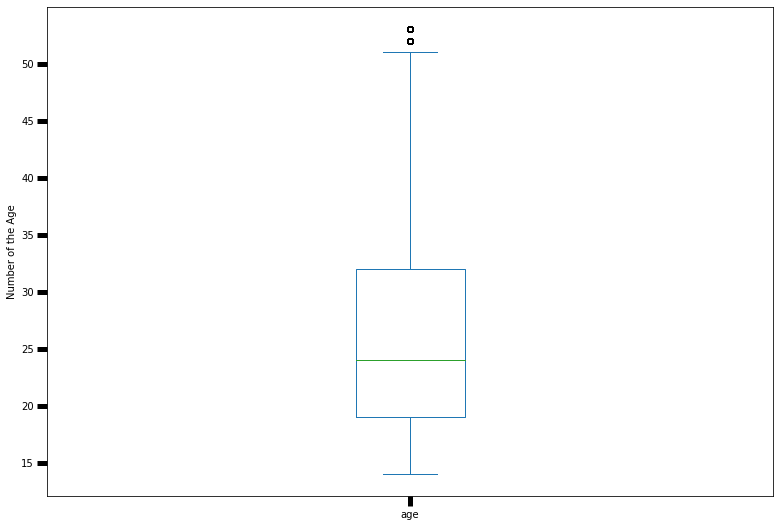

In [15]:
# Смотрим есть ли выбросы в признаке возраста
plt.figure(figsize = (13,9))
user_df.age.plot.box()
plt.ylabel('Number of the Age');

In [16]:
# Удаляем выбросы в age все что выше 98% квантиля
high_age_quantile = int(user_df.age.quantile(q = 0.98))
user_df = user_df[user_df['age']<high_age_quantile]

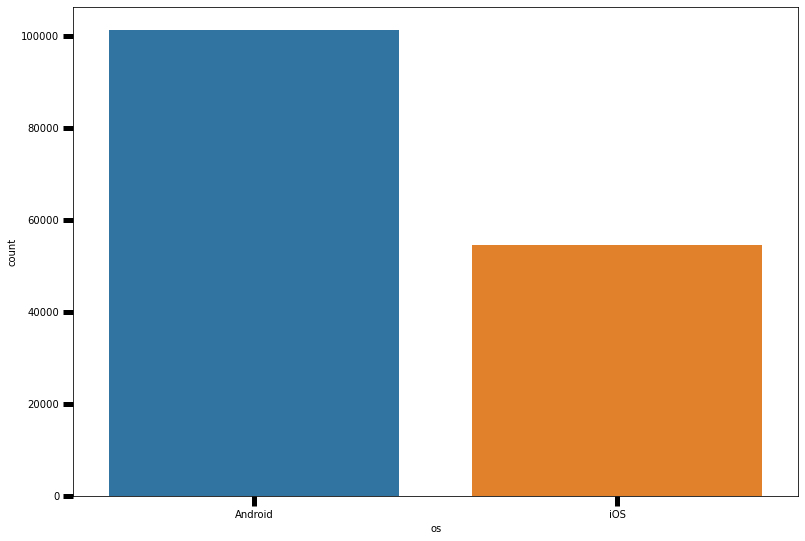

In [17]:
# Смотрим какая самая популярная операционная система у наших юзеров
plt.figure(figsize = (13,9))
sns.countplot(data = user_df , x = 'os');

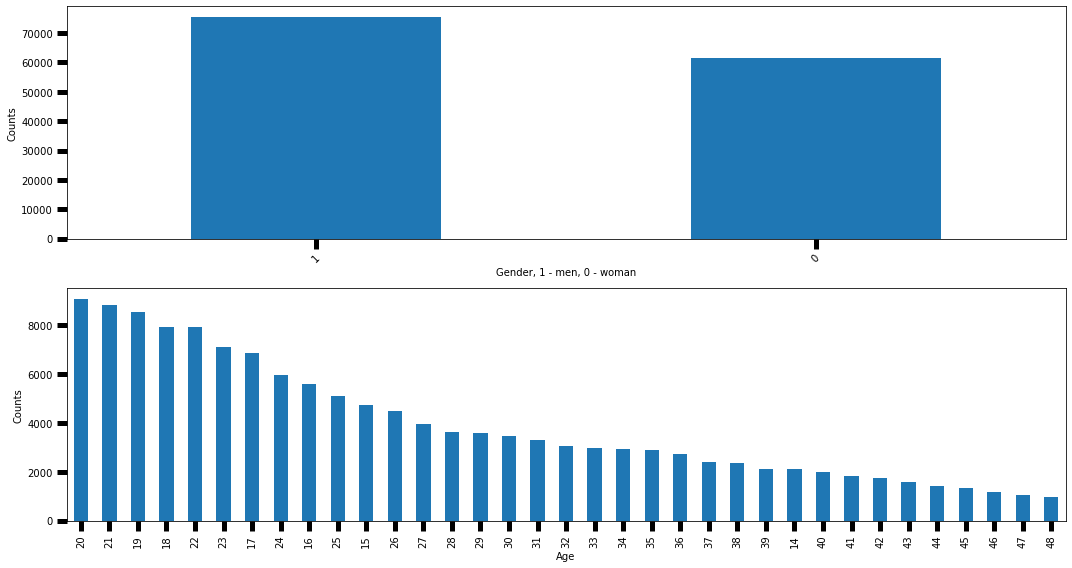

In [18]:
# Cмотрим кол-во женщин и мужчин в России 
counting_gender = user_df.query('country == "Russia"').gender.value_counts()
# А также средний возраст пользователей из России
counting_age = user_df.query('country == "Russia"').age.value_counts()

fig = plt.figure()
fig.set_size_inches(15, 8)
ax1 = fig.add_subplot(2, 1, 1)
counting_gender.plot(kind = 'bar')
plt.xlabel('Gender, 1 - men, 0 - woman', fontsize = 10)
plt.ylabel('Counts', fontsize = 10)
plt.xticks(rotation = 45);

ax2 = fig.add_subplot(2, 1, 2)
counting_age.plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.xlabel('Age', fontsize = 10)
plt.ylabel('Counts', fontsize = 10)
fig.tight_layout();

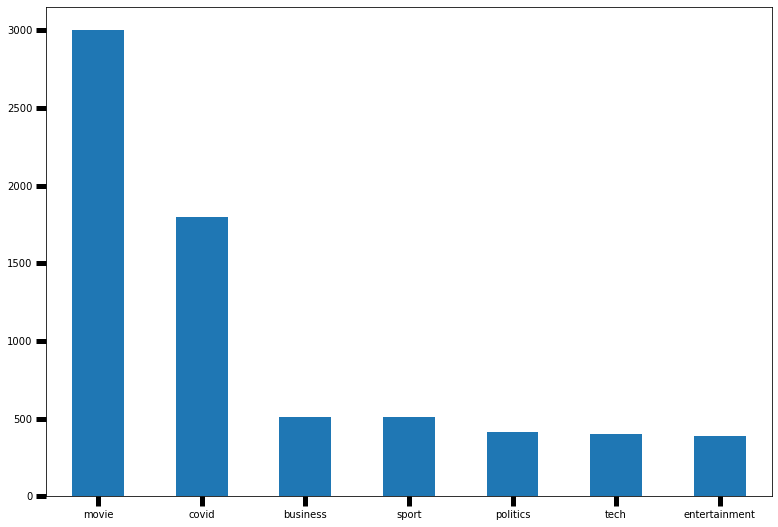

In [19]:
# Какие тематики самые популярные в нашей соц сети
plt.figure(figsize = (13,9))
topic_value_cnt = post_df.topic.value_counts()
topic_value_cnt.plot(kind = 'bar')
plt.xticks(rotation = 0);

In [21]:
print(f"Самая ранняя реакция пользователя по времени {feed_df.time.min()}")
print(f"Самая поздняя реакция пользователя по времени {feed_df.time.max()}")

Самая ранняя реакция пользователя по времени 2021-10-01 06:06:45
Самая поздняя реакция пользователя по времени 2021-12-29 23:51:06


## Предварительная подготовка данных к обучению

In [22]:
# Собираем общий датафрейм, сортируем нашу выборку по полю time по возрастанию и создаем фичи из даты timestamp
total_df = feed_df.merge(user_df).merge(post_df)
total_df = total_df.sort_values('time', ascending = True)
total_df['year'] = total_df.time.dt.year
total_df['month'] = total_df.time.dt.month
total_df['day'] = total_df.time.dt.day
total_df['hour'] = total_df.time.dt.hour
total_df.drop(columns = ['time', 'action'], inplace = True)

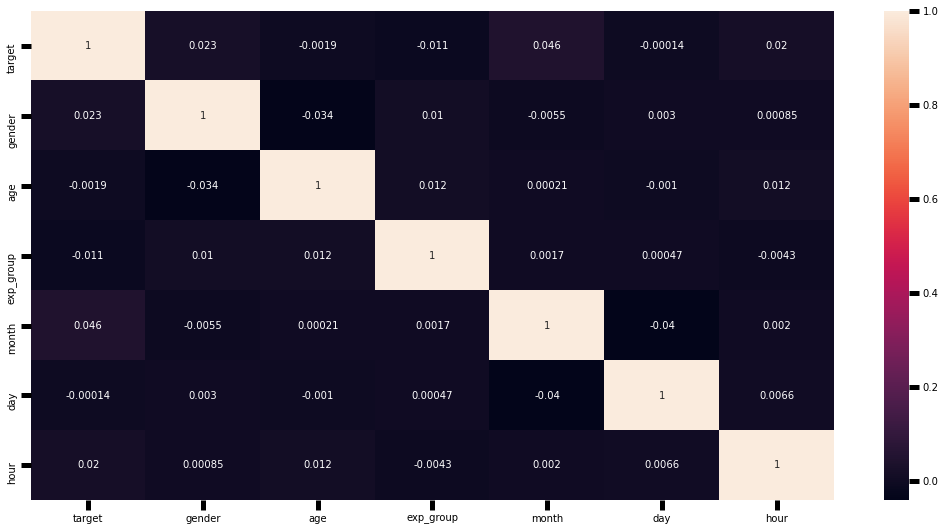

In [23]:
# Смотрим наличие сильных корреляций среди признаков
plt.figure(figsize=(18,9))
sns.heatmap(total_df.drop(columns=['user_id', 'post_id', 'year']).corr(), annot = True);

In [24]:
# Разбиваем нашу выборку на треин и тест, где в трейне 80% событий с начала октября по конец ноября 2021 года
# А в тесте находятся оставшиеся события с начала по конец декабря 2021 года
_train = total_df.iloc[:-20000].copy()
_test = total_df.iloc[-20000:].copy()

X_train = _train.drop(columns = ['target'])
y_train = _train.target
X_test = _test.drop(columns =  ['target'])
y_test = _test.target
# Узнаем индекс наших категориальных признаков и запоминаем текстовый признак для CatBoost'а
cat_features = ['os','source','topic','country','city' ,'user_id','post_id']
text_feature = ['text']
cat_features_idx = [list(X_train.columns).index(col) for col in cat_features]

In [25]:
# Создаем кастомную метрику для оценки перфоманса нашей модели
def custom_hitrate_metric(classifier, X, y_true, limit: int = 5):
    """
    Кастомная метрика hitrate. По умолчанию находим топ 5 рекомендаций-постов.
    Среди рекомендаций что мы показали пользователю есть хотя бы 1,
    которая на самом деле ему понравилась.
    На выходе усредняем кол-во понравившихся рекомендаций на общее кол-во
    уникальных юзеров выборки.    
    """
    
    y_pred = classifier.predict(X)
    y_pred_proba = classifier.predict_proba(X)[:,1]
    X_ = X.copy()
    
    X_['preds'] = y_pred
    X_['preds_proba'] = y_pred_proba
    X_['target'] = y_true
    
    count = 0 
    for user in X_['user_id'].unique(): 
        part = X_[X_['user_id'] == user] 
        part = part.sort_values('preds_proba', ascending=False).head(limit) 
        part = part[part['target'] == 1] 
        if (part['preds'] == part['target']).any():
            count += 1 
    return count / len(X_['user_id'].unique())

## Тренировка и предикт модели

In [27]:
# Так как у нас дисбаланс в классах попробуем установить гиперпараметр auto_class_weights, который будет перевзвешивать наши классы
catboost_model = CatBoostClassifier(learning_rate = 0.01, iterations = 100, cat_features = cat_features_idx, random_seed = 42,
                                    text_features = text_feature, auto_class_weights = 'Balanced')
catboost_model.fit(X_train, y_train)

0:	learn: 0.6927971	total: 1.3s	remaining: 2m 9s
1:	learn: 0.6924160	total: 2.51s	remaining: 2m 2s
2:	learn: 0.6921006	total: 3.4s	remaining: 1m 50s
3:	learn: 0.6916929	total: 4.31s	remaining: 1m 43s
4:	learn: 0.6913052	total: 5.44s	remaining: 1m 43s
5:	learn: 0.6909385	total: 6.49s	remaining: 1m 41s
6:	learn: 0.6906296	total: 7.49s	remaining: 1m 39s
7:	learn: 0.6902814	total: 8.58s	remaining: 1m 38s
8:	learn: 0.6899739	total: 9.65s	remaining: 1m 37s
9:	learn: 0.6896730	total: 10.5s	remaining: 1m 34s
10:	learn: 0.6893769	total: 11.7s	remaining: 1m 34s
11:	learn: 0.6890345	total: 13s	remaining: 1m 35s
12:	learn: 0.6886947	total: 14s	remaining: 1m 33s
13:	learn: 0.6883810	total: 15.1s	remaining: 1m 32s
14:	learn: 0.6880585	total: 16.1s	remaining: 1m 31s
15:	learn: 0.6877754	total: 17.1s	remaining: 1m 29s
16:	learn: 0.6874916	total: 18.1s	remaining: 1m 28s
17:	learn: 0.6871982	total: 19.2s	remaining: 1m 27s
18:	learn: 0.6869271	total: 20s	remaining: 1m 25s
19:	learn: 0.6866542	total: 20.9

## Оцениваем перфоманс нашей модели

In [28]:
print(f" Hitrate@5 на трейне: {round(custom_hitrate_metric(catboost_model, X_train, y_train),3)}")
print(f" Hitrate@5 на тесте: {round(custom_hitrate_metric(catboost_model, X_test, y_test),3)}")

 Hitrate@5 на трейне: 0.581
 Hitrate@5 на тесте: 0.522


Порог в 0.4 метрики `Hitrate@5` пройден. В среднем наша модель в 2-3 из 5 постов рекомендует посты, которые нравятся  пользователям соц сети.

In [29]:
print("TRAIN \n",classification_report(y_train, catboost_model.predict(X_train)))
print("TEST \n",classification_report(y_test, catboost_model.predict(X_test)))

TRAIN 
               precision    recall  f1-score   support

           0       0.94      0.54      0.69    832978
           1       0.16      0.73      0.26     98557

    accuracy                           0.56    931535
   macro avg       0.55      0.64      0.48    931535
weighted avg       0.86      0.56      0.64    931535

TEST 
               precision    recall  f1-score   support

           0       0.93      0.49      0.64     17597
           1       0.17      0.74      0.27      2403

    accuracy                           0.52     20000
   macro avg       0.55      0.62      0.46     20000
weighted avg       0.84      0.52      0.60     20000



Матрица ошибок на трейне


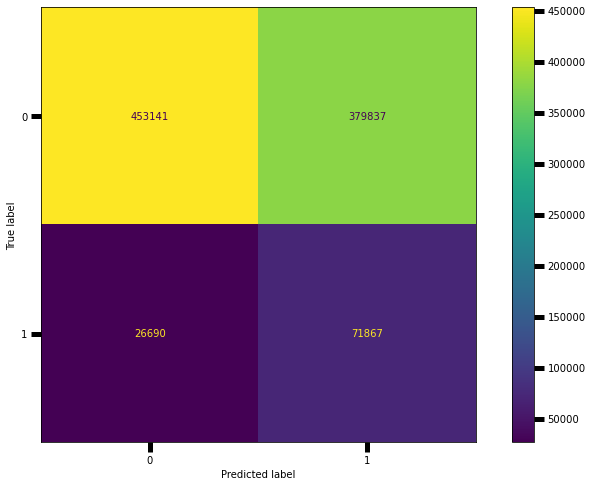

In [30]:
print("Матрица ошибок на трейне")
cm = confusion_matrix(y_train, catboost_model.predict(X_train), labels=catboost_model.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(13,8))
cmp.plot(ax=ax)

plt.show()

Матрица ошибок на тесте


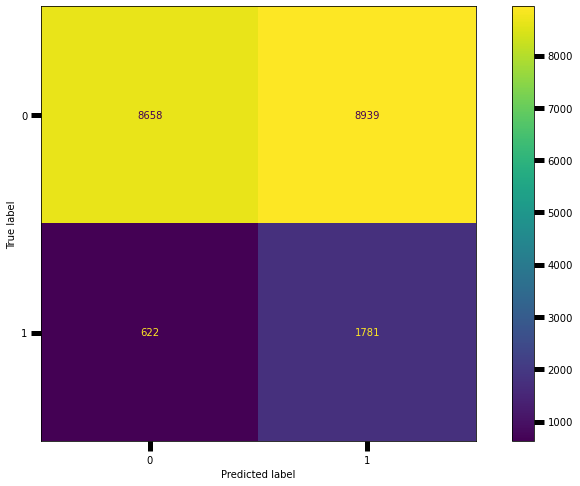

In [31]:
print("Матрица ошибок на тесте")
cm = confusion_matrix(y_test, catboost_model.predict(X_test), labels=catboost_model.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(13,8))
cmp.plot(ax=ax)

plt.show()

Отчет по классификации и матрица ошибок показывают, что метрика `precision` для 1-ого класса у нашей модели низкий, а `recall` достаточно высокий, что говорит нам о том, что мы часто ошибаемся в классификации 1-ого класса и благодаря высокому покрытию `recall` угадываем большой процент постов, которые понравятся нашим пользователям. С 0-ым классом обстоят дела лучше, мы гораздо реже ошибаемся в его прогнозе. В целом для рекомендательной системы социальной сети - это приемлемый результат.  

## Сохраняем нашу модель для сервиса рекомендательной системы

In [32]:
catboost_model.save_model('catboost_model',
                           format="cbm")